### ST446 Distributed Computing for Big Data, LT 2021

# Seminar 10: Distributed dataflow graph computations

## Exercise 2: Distributed training with `MirroredStrategy()`: single machine with multiple GPUs 

## Overview

This tutorial is adapted from [mnist-keras-mirror](https://www.tensorflow.org/tutorials/distribute/keras).

The `tf.distribute.Strategy` API provides an abstraction for distributed training of a machine learning model across multiple processing units. The goal is to allow users to enable distributed training using existing models and training code, with minimal changes.

This exercise uses the `tf.distribute.MirroredStrategy`, which performs in-graph replication with synchronous training on multiple GPUs on a single machine. This strategy replicates the model and maintains globally consistent parameters ("mirrored variables") on each device. The mirrored variables are kept globally consistent by applying the same updates on them by each device. Specifically, in the distributed training scenario, mirrored variables are kept globally consistent by applying the same gradient descent updates on model parameters by all devices within each synchronous iteration step. The gradient updates are communicated amount devices by using a distributed [all-reduce](http://mpitutorial.com/tutorials/mpi-reduce-and-allreduce/) algorithm.

`MirroredStrategy` is one of several distribution strategies available in TensorFlow core. You can read more about strategies at [distribution strategy guide](https://www.tensorflow.org/guide/distributed_training).

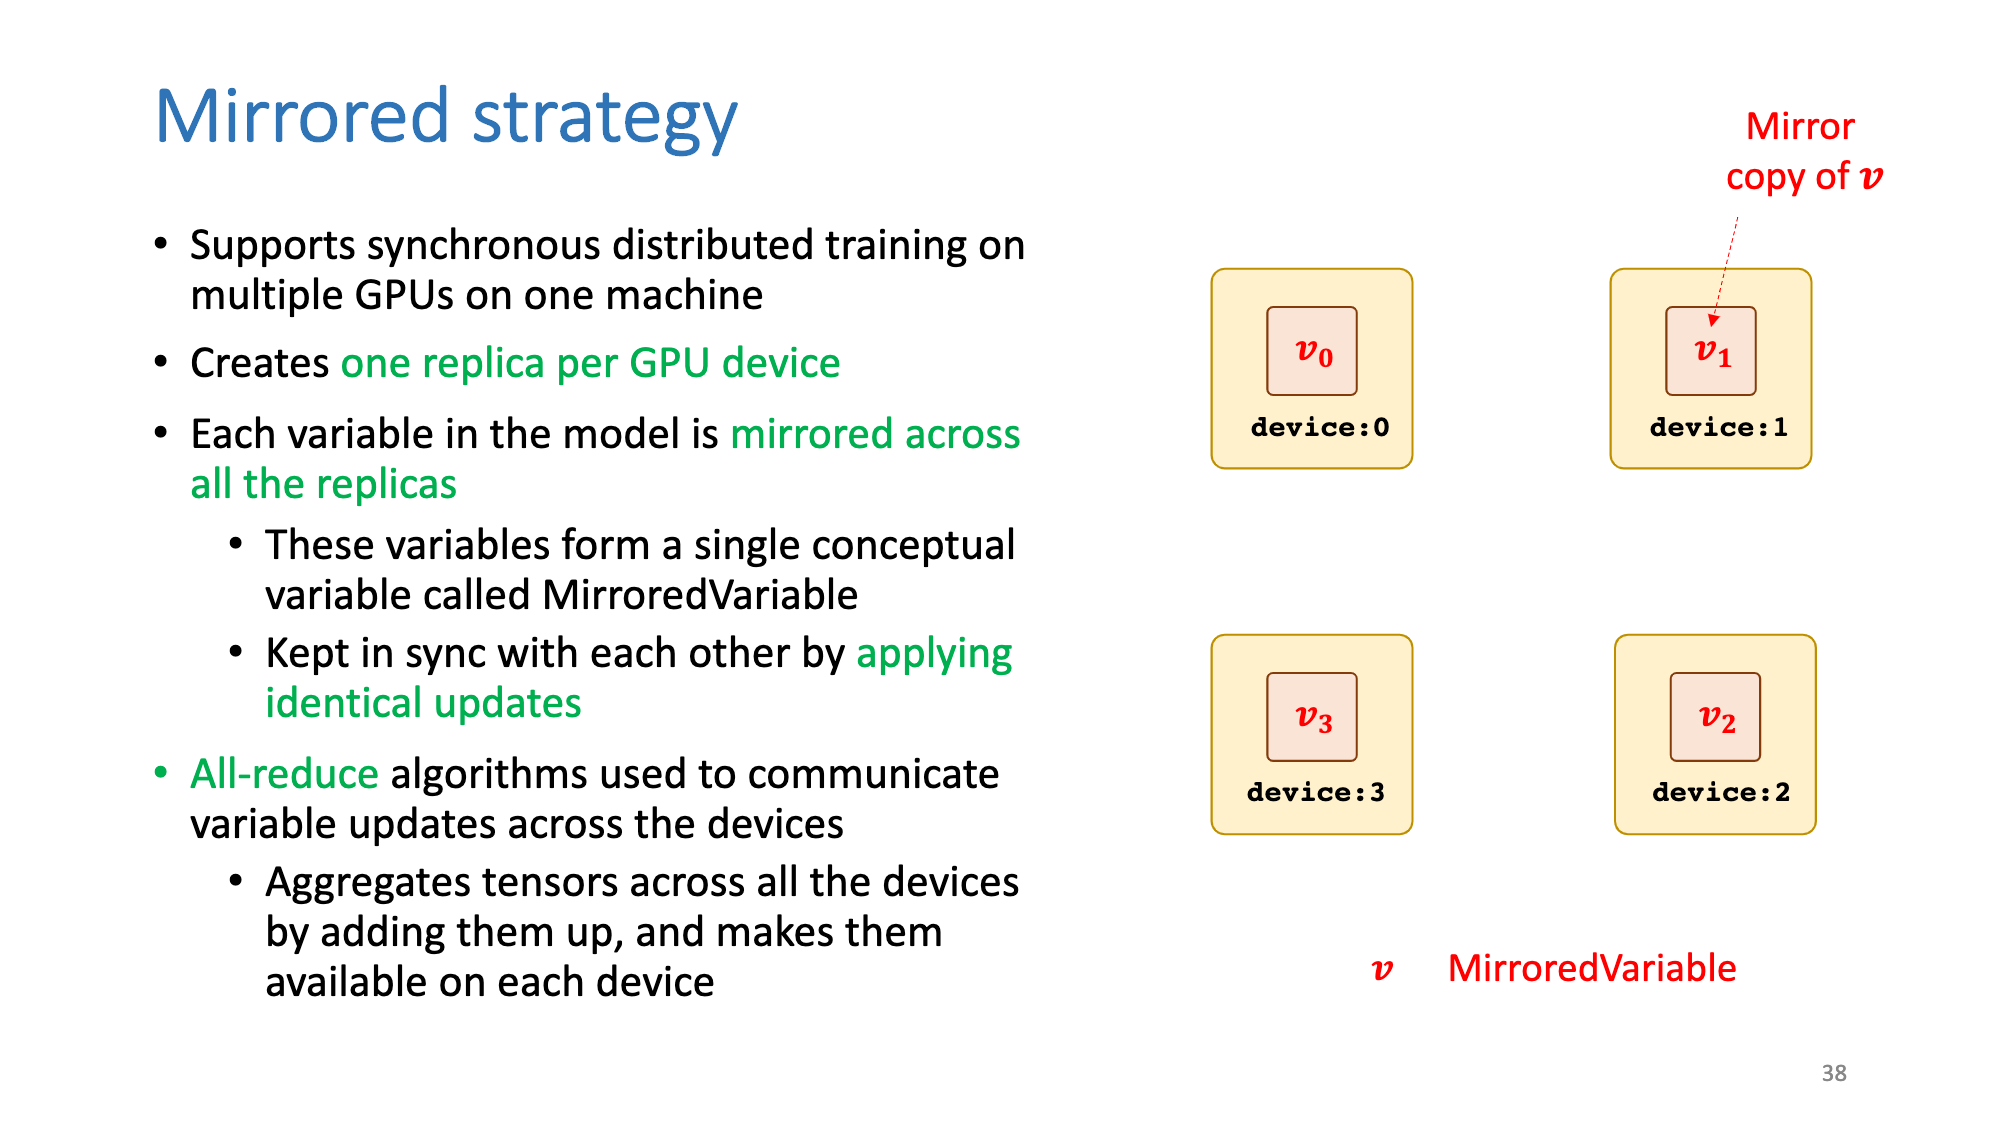

In [2]:
import IPython
IPython.display.Image("figs/mirrored.png")

### Keras API

This example uses the `tf.keras` API to build the model and training loop. For custom training loops, see the tutorial [tf.distribute.Strategy with custom training loops](https://www.tensorflow.org/tutorials/distribute/custom_training).

## Prerequisites

To run this jupyter notebook, we must have a machine with 2 (or more) GPUs. We will use Google Cloud AI Notebook to create a virtual machine instance with 2 [NVIDIA Tesla T4 GPUs](https://www.nvidia.com/en-gb/data-center/tesla-t4/) (the only available GPUs at Google's datacenter in London).

### Step 1: Request quotas for GPUs

Check the [quotas page](https://console.cloud.google.com/iam-admin/quotas?_ga=2.215982551.1900303284.1585843595-1894457944.1576246827) to ensure that you have enough GPUs available for your project. 

Normally, you will only have 1 quota for GPU at the begining. Follow the [request a quota increase](https://cloud.google.com/compute/quotas#requesting_additional_quota) page to submit a request.

In the quota page on your GCP console, you need to choose *NVIDIA Tesla T4 GPU* as the `metric` and *europe-west2* as the `location` and click on `Edit quotas` to submit your request.

We suggest that you increase your limit to 4 in case you need them for your project.

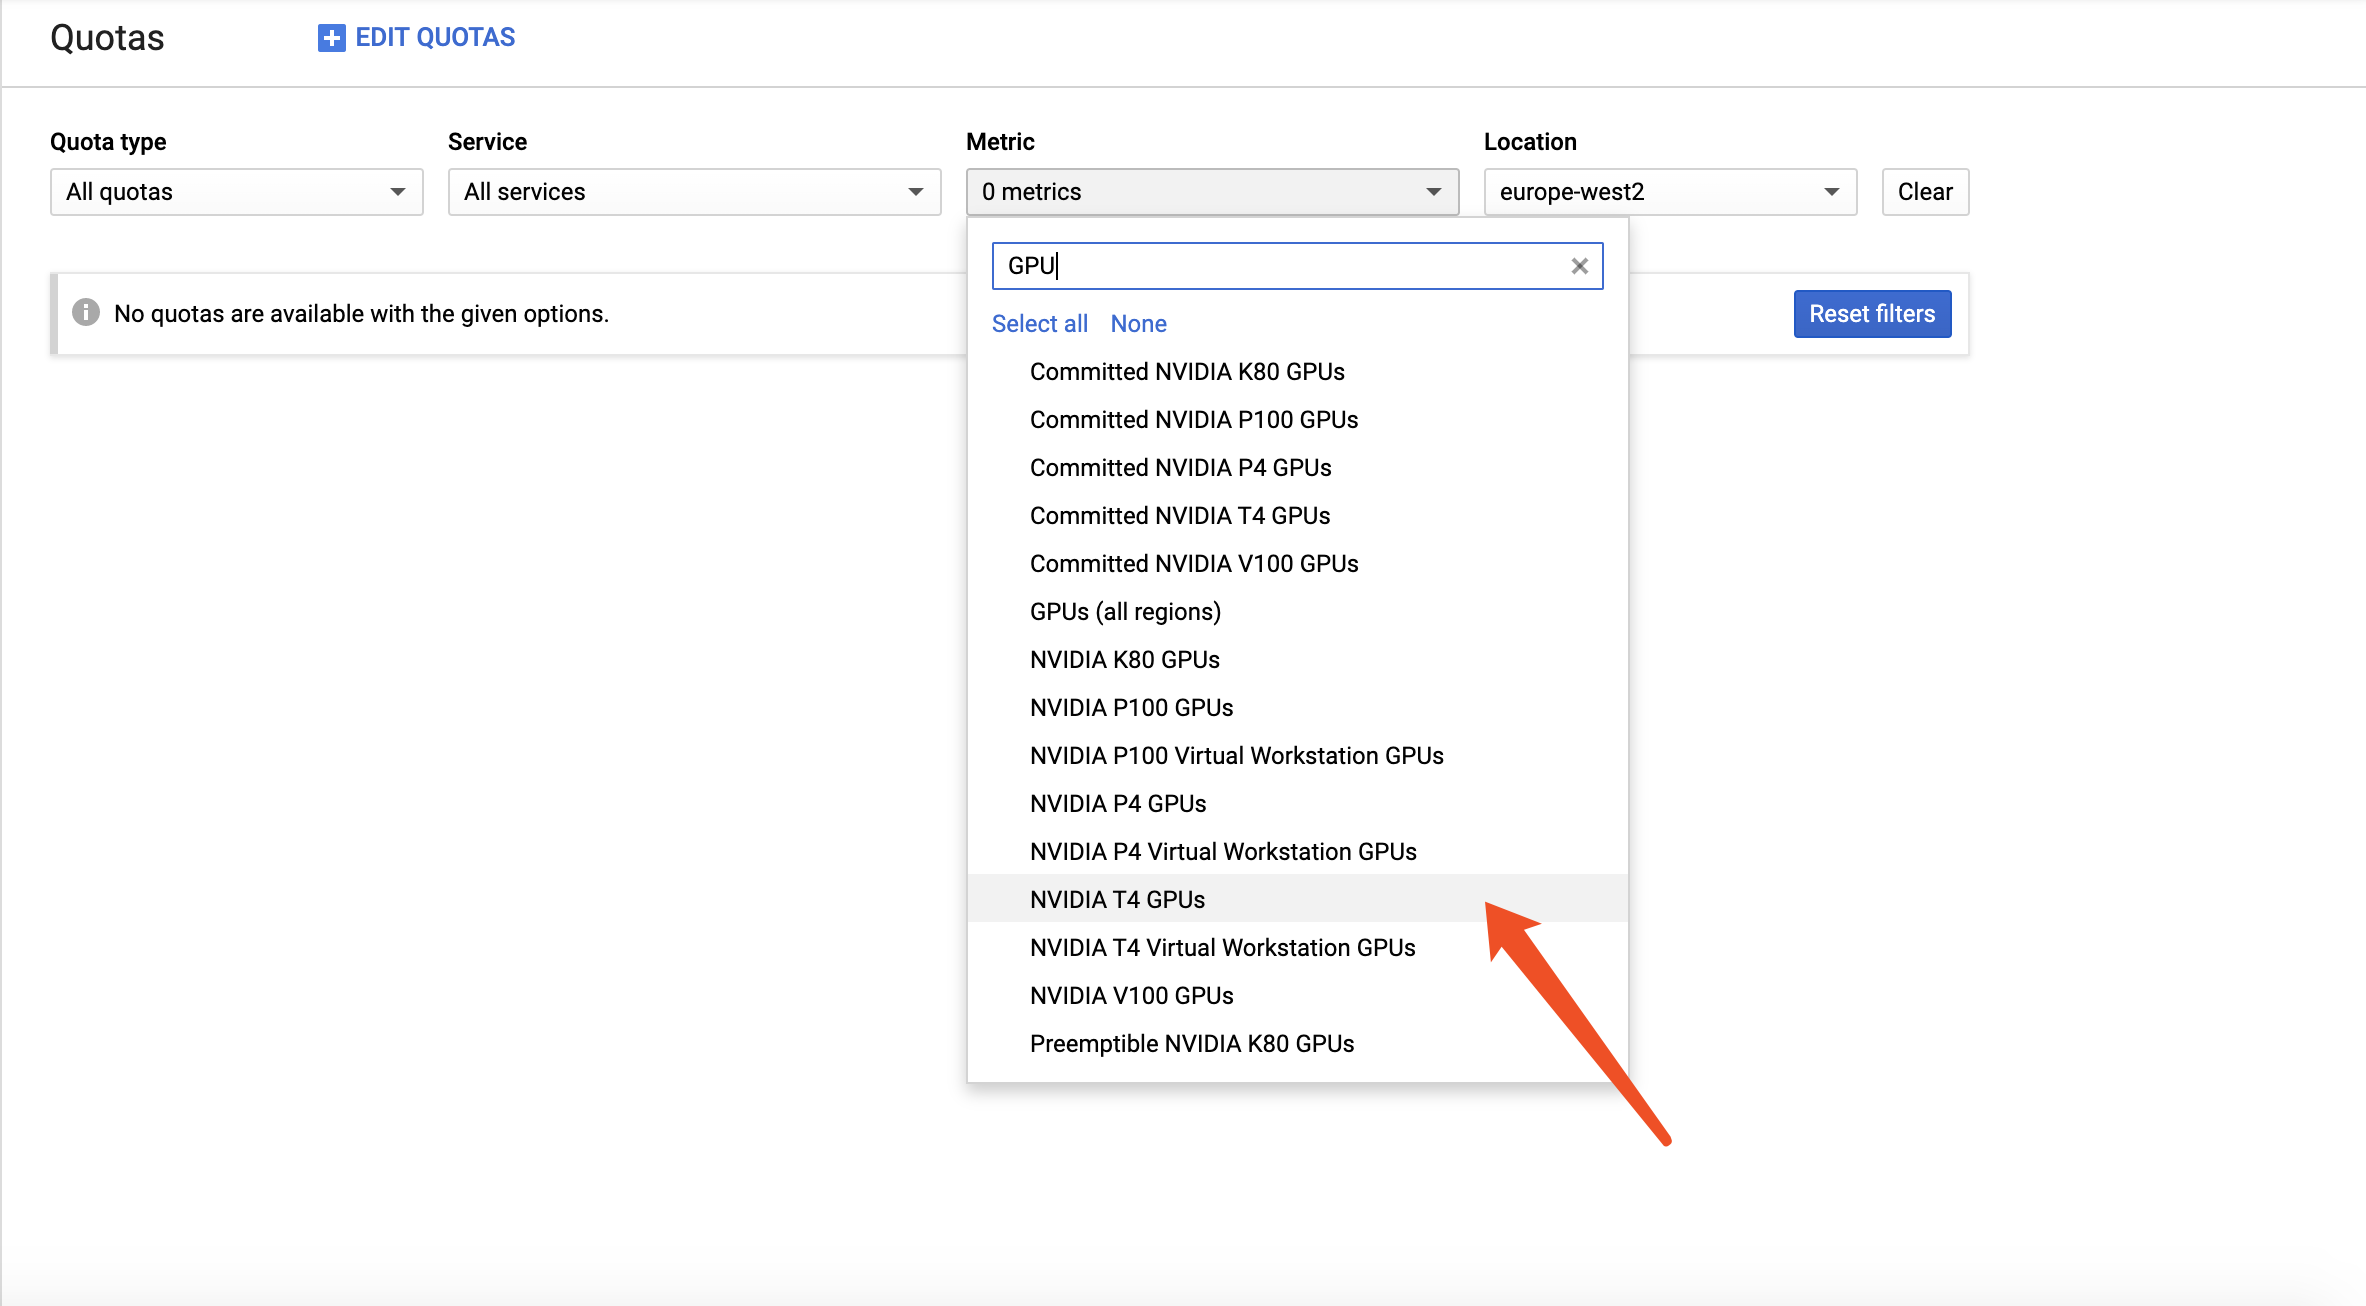

In [3]:
IPython.display.Image("figs/quotas.png")

### Step 2: Create your AI notebook instance

You can create the instance using [Notebook UI](https://console.cloud.google.com/mlengine/notebooks) or running the command lines below in your terminal or GCP cloud shell:

```
export INSTANCE_NAME="your-instance-name"
export IMAGE_FAMILY="tf2-latest-gpu" # TensorFlow 2
export ZONE="europe-west2-a"
export INSTANCE_TYPE="n1-standard-4"
gcloud compute instances create $INSTANCE_NAME \
  --zone=$ZONE \
  --image-family=$IMAGE_FAMILY \
  --machine-type=$INSTANCE_TYPE \
  --image-project=deeplearning-platform-release \
  --maintenance-policy=TERMINATE \
  --accelerator='type=nvidia-tesla-t4,count=2' \ # 2 GPUs
  --no-boot-disk-auto-delete \
  --boot-disk-device-name=$INSTANCE_NAME-disk \
  --boot-disk-size=500GB \
  --boot-disk-type=pd-ssd \
  --scopes=https://www.googleapis.com/auth/cloud-platform \
  --metadata='install-nvidia-driver=True,proxy-mode=project_editors'
```

Your VM will be created a few minutes after the gcloud command finished. A few minutes after that, your VM is assigned a URL for direct connection and appears in the [AI Platform Notebooks UI](https://console.cloud.google.com/mlengine/notebooks):

![ai-notebooks](https://miro.medium.com/max/1400/1*FZH4O2X-Rfmp9OStHxZszA.png)

Once the notebook is created, click on `OPEN JUPYTERLAB` and then you’ll see the default AI Platform Notebooks JupyterLab UI.

![jupyterlab](https://miro.medium.com/max/1400/1*ACY2R_wG8J_dL6UuzHMylw.png)

You may not have this `TensorBoard` extension which is still under development for the jupyterlab with TensorFlow 2.x. 


### Step 3: Upload this jupyter notebook to the jupyterlab

## Import dependencies

In [1]:
# Import TensorFlow and TensorFlow Datasets
import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()

import os

In [2]:
print(tf.__version__)

2.1.0


## Download the dataset

Download the MNIST dataset and load it from [TensorFlow Datasets](https://www.tensorflow.org/datasets). This returns a dataset in `tf.data` format.

Setting `with_info` to `True` includes the metadata for the entire dataset, which is being saved here to `info`.
Among other things, this metadata object includes the number of the train and test examples. 


In [3]:
datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)

mnist_train, mnist_test = datasets['train'], datasets['test']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset mnist downloaded and prepared to /home/jupyter/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


## Define distribution strategy

Create a `MirroredStrategy` object. This will handle distribution, and provides a context manager (`tf.distribute.MirroredStrategy.scope`) to build your model inside.

In [4]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [5]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


## Setup input pipeline

When training a model with multiple GPUs, you can use the extra computing power effectively by increasing the batch size. In general, use the largest batch size that fits the GPU memory, and tune the learning rate accordingly.

In [6]:
# You can also do info.splits.total_num_examples to get the total
# number of examples in the dataset.

num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples

BUFFER_SIZE = 10000

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

Pixel values, which take interger values from 0 to 255, have to be normalized to the 0-1 range ([feature scaling](https://en.wikipedia.org/wiki/Feature_scaling)). Define this scaling by the following function.

In [7]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255

  return image, label

Apply this function to the training and test data, shuffle the training data, and [batch it for training](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch). Notice we are also keeping an in-memory cache of the training data to improve performance.


In [8]:
train_dataset = mnist_train.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
eval_dataset = mnist_test.map(scale).batch(BATCH_SIZE)

## Create the model

Create and compile the Keras model in the context of `strategy.scope`.

In [9]:
with strategy.scope():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10)
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


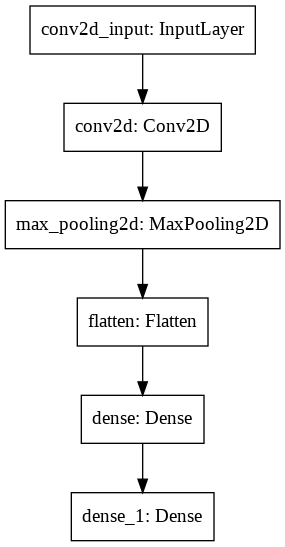

In [1]:
import IPython
IPython.display.Image("figs/cnn.png")

## Define the callbacks


The callbacks used here are:

*   *TensorBoard*: This callback writes a log for TensorBoard which allows you to visualize the graphs.
*   *Model Checkpoint*: This callback saves the model after every epoch.
*   *Learning Rate Scheduler*: Using this callback, you can schedule the learning rate to change after every epoch/batch.

For illustrative purposes, add a print callback to display the *learning rate* in the notebook.

In [10]:
# Define the checkpoint directory to store the checkpoints

checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [11]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 and epoch < 7:
    return 1e-4
  else:
    return 1e-5

In [12]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [13]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

## Train and evaluate

Now, train the model in the usual way, calling `fit` on the model and passing in the dataset created at the beginning of the tutorial. This step is the same whether you are distributing the training or not.


In [14]:
model.fit(train_dataset, epochs=12, callbacks=callbacks)

Epoch 1/12
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


    469/Unknown - 15s 33ms/step - loss: 0.2470 - accuracy: 0.9300
Learning rate for epoch 1 is 0.0010000000474974513
469/469 [==============================] - 15s 33ms/step - loss: 0.2470 - accuracy: 0.9300
Epoch 2/12
465/469 [============================>.] - ETA: 0s - loss: 0.0812 - accuracy: 0.9755
Learning rate for epoch 2 is 0.0010000000474974513
469/469 [==============================] - 3s 7ms/step - loss: 0.0810 - accuracy: 0.9756
Epoch 3/12
462/469 [============================>.] - ETA: 0s - loss: 0.0563 - accuracy: 0.9833
Learning rate for epoch 3 is 0.0010000000474974513
469/469 [==============================] - 3s 7ms/step - loss: 0.0560 - accuracy: 0.9834
Epoch 4/12
466/469 [============================>.] - ETA: 0s - loss: 0.0356 - accuracy: 0.9901
Learning rate for epoch 4 is 9.999999747378752e-05
469/469 [==============================] - 3s 7ms/step - loss: 0.0357 - accuracy: 0.9901
Epoch 5/12
464/469 [============================>.] - ETA: 0s - loss: 0.0325 - accur

As you can see below, the checkpoints are getting saved.

In [15]:
# check the checkpoint directory
!ls {checkpoint_dir}

checkpoint		     ckpt_4.data-00000-of-00002
ckpt_10.data-00000-of-00002  ckpt_4.data-00001-of-00002
ckpt_10.data-00001-of-00002  ckpt_4.index
ckpt_10.index		     ckpt_5.data-00000-of-00002
ckpt_11.data-00000-of-00002  ckpt_5.data-00001-of-00002
ckpt_11.data-00001-of-00002  ckpt_5.index
ckpt_11.index		     ckpt_6.data-00000-of-00002
ckpt_12.data-00000-of-00002  ckpt_6.data-00001-of-00002
ckpt_12.data-00001-of-00002  ckpt_6.index
ckpt_12.index		     ckpt_7.data-00000-of-00002
ckpt_1.data-00000-of-00002   ckpt_7.data-00001-of-00002
ckpt_1.data-00001-of-00002   ckpt_7.index
ckpt_1.index		     ckpt_8.data-00000-of-00002
ckpt_2.data-00000-of-00002   ckpt_8.data-00001-of-00002
ckpt_2.data-00001-of-00002   ckpt_8.index
ckpt_2.index		     ckpt_9.data-00000-of-00002
ckpt_3.data-00000-of-00002   ckpt_9.data-00001-of-00002
ckpt_3.data-00001-of-00002   ckpt_9.index
ckpt_3.index


To see how the model perform, load the latest checkpoint and call `evaluate` on the test data.

Call `evaluate` as before using appropriate datasets.

In [16]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

eval_loss, eval_acc = model.evaluate(eval_dataset)

print('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

     79/Unknown - 3s 34ms/step - loss: 0.0429 - accuracy: 0.9848Eval loss: 0.04293173860428454, Eval Accuracy: 0.9847999811172485


In [17]:
!ls -sh ./logs

total 4.0K
4.0K train


## Export to SavedModel

Export the graph and the variables to the platform-agnostic SavedModel format. After your model is saved, you can load it with or without the scope.


In [18]:
path = 'saved_model/'

In [19]:
model.save(path, save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Load the model without `strategy.scope`.

In [20]:
unreplicated_model = tf.keras.models.load_model(path)

unreplicated_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

eval_loss, eval_acc = unreplicated_model.evaluate(eval_dataset)

print('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

     79/Unknown - 1s 17ms/step - loss: 0.0429 - accuracy: 0.9848Eval loss: 0.04293173829777331, Eval Accuracy: 0.9847999811172485


Load the model with `strategy.scope`.

In [21]:
with strategy.scope():
  replicated_model = tf.keras.models.load_model(path)
  replicated_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

  eval_loss, eval_acc = replicated_model.evaluate(eval_dataset)
  print ('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

     79/Unknown - 3s 34ms/step - loss: 0.0429 - accuracy: 0.9848Eval loss: 0.04293173860428454, Eval Accuracy: 0.9847999811172485


### Examples and Tutorials
Here are some further examples for using distribution strategy with keras fit/compile:
1. [Transformer](https://github.com/tensorflow/models/blob/master/official/nlp/transformer/transformer_main.py) example trained using `tf.distribute.MirroredStrategy`
2. [NCF](https://github.com/tensorflow/models/blob/master/official/recommendation/ncf_keras_main.py) example trained using `tf.distribute.MirroredStrategy`.

More examples are listed in the [Distribution strategy guide](https://www.tensorflow.org/guide/distributed_training).